In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt

from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


In [ ]:
'''
Authors: 
Andrea Pimpinella <andrea.pimpinella@polimi.it>,
Alessandro E. C. Redondi <alessandroenrico.redondi@polimi.it>
Antonio Capone  <alessandroenrico.redondi@polimi.it>

This code preprocesses raw data and perform features extraction for Prediction Model of Video Quality Long Term QoE
use case.
'''

In [3]:
#USEFUL FUNCTIONS FOR PLOTTING

def plot_cdf(data, votes, bin_edges, ax, xlabel=None, color=None):

    '''
    This function is useful to understand whether in inout feature "data" there is information which is correlated to the
    satisfaction of the users.
    Generally speaking, the meaning of the CDFs is that, if there is a gap between the distributions of the data
    conditioned to the satisfaction class of the corresponding users, it means that the information in the data is
    correlated to users satisfaction and thus can be learnt by a supervised classifier.
    Generally speaking, looking at data distributions is the first step to decide whether some data may be useful or
    not for ML problems.
    :param data: data to be plot (one-dimensional array)
    :param votes: satisfaction labels, int; if already binary, set threshold to None
    :param bin_edges: array of type  np.linspace(min(data), max(data), num_bins+1)
    :param ax: axis of type plt.subplots(figsize=(a,b));
    :param xlabel: label to gice to x axis
    :param color: axis color
    :return:
    '''

    if xlabel is None:
        xlabel = 'your data'
    if color is None:
        color = 'black'

    yt = votes.copy()

    neg, _ = np.histogram(data[yt == +1], bins=bin_edges)  # count number of evidences per bin
    pos, _ = np.histogram(data[yt == 0], bins=bin_edges)

    sumpos =  sum(pos)
    sumneg =  sum(neg)
    pos = pos.astype(float) / sumpos  # normalize to total number of evidences
    neg = neg.astype(float) / sumneg

    xrange = bin_edges[1:] - bin_edges[:1]
    
    title = 'CDF'
    ax.plot(xrange, np.cumsum(pos))
    ax.plot(xrange, np.cumsum(neg))
    ax.xaxis.label.set_color(color)
    ax.yaxis.label.set_color(color)
    ax.tick_params(axis='x', colors=color)
    ax.tick_params(axis='y', colors=color)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.set_xlabel(xlabel)
    ax.set_title(title, color=color)
    ax.legend(['High QoE', 'Low QoE'])
    return

# USEFUL FUNCTIONS FOR PREDICTION

def hyperparameter_tuning(train_sample, train_target, names, classifiers, parameters_grid,
                          n_splits_in=None, ref_metric=None):
    '''
    This function applies a cross validation strategy to select, for each of the classifiers provided in input, 
    the best hyper-parameters (hp) values out of a pool of candidate values (Grid Search Procedure). 
    The function saves on a file the best hp values, for the input Training Fold. Finally, it returns the prediction 
    performance on the input Validation Fold.
    (ref: https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/)

    :param train_sample: training samples set
    :param train_target: training users satisfaction labels
    :param test_sample: test samples set
    :param test_target: test users satisfaction labels
    :param names: involved classifiers names
    :param classifiers: involved classifiers scikitlearn functions
    :param n_splits_in: number of k fold splits for validation (our results were derived with 10 folds, which is the default value)
    :param ref_metric: optimization metric (sklearn.metrics); default roc_auc
    :return: prediction performance on the test set (AUC)
    '''

    if ref_metric is None:
        ref_metric = 'roc_auc'
    if n_splits_in is None:
        n_splits_in = 2

    best_hp = pd.DataFrame(index = names, columns = ['BestHP_Values'])
    print('Choose Best hyper-parameters through Cross Validation')
    text_file = open('Best_hyper-parameters (HP Tuning).txt', "w") # If this filename already exists in folder, 
    # results will be appended to older file. Delete older version to fill a new txt file.
    text_file.write("############\n")
    for name, clf in zip(names, classifiers):
        text_file.write("{}:\n".format(name))
        print("############")
        print(' Classifier {} - Processing'.format(name))
        grid = parameters_grid[names.index(name)] #take hyper-parameters candidate values grid 
        estimator = model_selection.GridSearchCV(clf, grid, scoring=ref_metric, iid=True,refit=True,
                                                 cv=n_splits_in).fit(train_sample, train_target) #Grid Search 
        bp = estimator.best_params_
        print(' Best Parameters Values: {}'.format(bp))
        print(list(bp.values()))
        best_hp.at[name,'BestHP_Values'] = list(bp.values())
        text_file.write("{}:\n".format(estimator.best_params_))
        text_file.write("############\n")
        print("############")
    text_file.write("******************\n")
    text_file.close()

    return best_hp
    

def direct_prediction(train_sample, train_target, test_sample, test_target, names, classifiers):
    '''
    This function takes in input a group of classifiers with already fixed HP values, train them on the input data 
    train_sample --> train_target and finally performs prediction on the input test_sample-->test_target. 
    
    Note that each classifier outputs the probability that a given test user belongs to the
    class of Dissatisfied Users. By thresholding such probability, one can effectively assign to the test user 
    either the Satisfied ('0') or the Dissatisfied ('1') label. Computing the FPR and TPR of the classifier for 
    different threshold values, it is possible to draw a ROC Curve.
    Finally, the performance in terms of Area Under the ROC Curve are returned as output.
    (ref: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
    
    
    :param train_sample: training samples set
    :param train_target: training users satisfaction labels
    :param test_sample: test samples set
    :param test_target: test users satisfaction labels
    :param names: names of the considered classifiers 
    :param classifiers: the scikit methods corresponding to the considered classifiers
    :return: prediction performance (AUC) on the test set
    '''
    
    perf = pd.DataFrame(index=names,columns=['AUC'])
    prediction_proba = np.empty((len(names), len(test_sample)))

    plt.figure(figsize=(20, 5))
    color = ['b', 'r', 'g', 'c', 'k', 'm'] #choose a color for each classifier
    color = color[:len(names)]
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.3) # ROC Curve of a dummy 
    # Classifier
    for name, clf in zip(names, classifiers):
        print(' Classifier {} - Fit & Predict'.format(name))
        estimator = clf.fit(train_sample, train_target) # fit the classifier on training set

        prediction_proba[names.index(name),:] = estimator.predict_proba(test_sample)[:, 1] # generate, for each test
        # user, the probability that the user is not satisfied

        fpr, tpr, decision_thresholds = metrics.roc_curve(test_target, prediction_proba[names.index(name),:]
                                                          , pos_label=1)

        perf.at[name,'AUC'] = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color[names.index(name)], label=r'ROC %s (AUC = %0.3f)' % (name,perf.loc[name,
                                                                                                          'AUC']), lw=2, alpha=.8)
        perf.at[name,'AUC'] = metrics.auc(fpr, tpr)
    
    plt.plot(0, 1, '*', color='k', label=r'Optimum: FPR = 0, TPR = 1', lw=2, alpha=.8, markersize=15)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xticks(color='black')
    plt.yticks(color='black')
    plt.grid(1)
    plt.xlabel('False Positive Rate', color='black', fontsize=14)
    plt.ylabel('True Positive Rate', color='black', fontsize=14)
    plt.legend(loc="lower right")
    plt.show()
    #plt.savefig('ROC.png', bbox_inches='tight') #uncomment to save the plot
    return perf


        

# Import Training Data

In [6]:
if 'dataset' in globals():
    del dataset
if 'ground_truth' in globals():
    del ground_truth

path = 'data/' # PUT YOUR FILE PATH
basic_train = pd.read_csv(path+'BasicDataset_Training_MRN.csv')

dataset = basic_train.drop(['User_Satisfaction','Unnamed: 0', 'Unnamed: 0.1'], axis=1)
ground_truth = basic_train.loc[:, 'User_Satisfaction'].copy()
print('Train Data:', dataset.shape)
print('Train Target:', ground_truth.shape)



Train Data: (18970, 12)
Train Target: (18970,)


In [ ]:
list(dataset.columns)
dataset.head()

,Cumulative_YoutubeSess_LTE_DL_Time,Cumulative_YoutubeSess_LTE_DL_Volume,Cumulative_YoutubeSess_UMTS_DL_Time,Cumulative_YoutubeSess_UMTS_DL_Volume,Max_RSRQ,Max_SNR,Cumulative_Full_Service_Time_UMTS,Cumulative_Lim_Service_Time_UMTS,Cumulative_No_Service_Time_UMTS,Cumulative_Full_Service_Time_LTE,Cumulative_Lim_Service_Time_LTE,Cumulative_No_Service_Time_LTE
0,100.727,110854.0,0.000,0.0,-6.0,27.8,53917,5636,2043,213227,3996,2883
1,9.324,93.0,0.000,0.0,-3.0,-19.8,85021,1761,1223,87700,4287,1251
2,2715.406,2271118.0,580.907,63891.0,-3.0,-19.8,123462,4664,2715,203846,5776,8748
3,74.097,39065.0,0.000,0.0,-4.0,-19.8,85675,4903,1322,7924,1799,9491
4,168.955,41933.0,0.000,0.0,-3.0,-19.9,104902,2068,669,137121,3846,937


In [ ]:
ground_truth.value_counts()
ground_truth.head()

0    1.0
1    0.0
2    0.0
3    0.0
4    1.0
Name: User_Satisfaction, dtype: float64

# Data Visualization

In [7]:
# Here Plot and PreProcess Data for a first Overview and Preliminary Analysis

#Visual Tools: Data Distribution, etc.

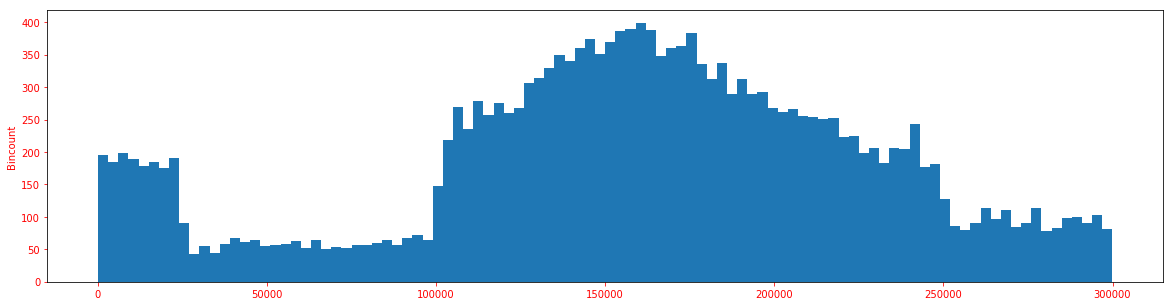

In [ ]:
# Plot Distribution of Cum. Full Service Time in LTE 
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
x = dataset.Cumulative_Full_Service_Time_LTE
tmp_0 = ax.hist(x, bins=100)
ax.set_ylabel('Bincount')
ax.xaxis.label.set_color('red')
ax.yaxis.label.set_color('red')
ax.tick_params(axis='x', colors='red')
ax.tick_params(axis='y', colors='red')

# Features Engineering

In [8]:
# Here Create Features: transform basic features (if needed), create new features, exclude unnecessary
# features (i.e., those which are not correlated with target)

#Visual Tools: Conditional CDFs with respect to user lables, Conditional Pair-Wise ScatterPlots, etc.  
#Mathematical Tools: Mathematical Ttransformations, Features-Target Correlation Analysis, etc.

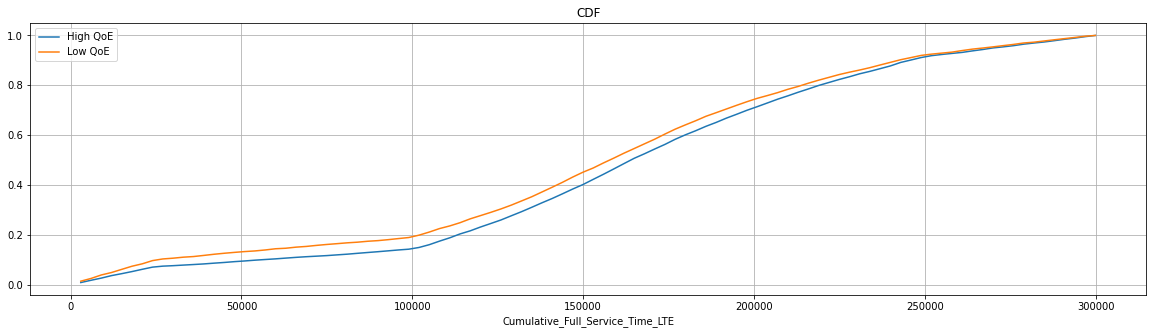

In [9]:
fig, aax = plt.subplots(1, 1, figsize=(20, 5))
x = dataset.Cumulative_Full_Service_Time_LTE
y = ground_truth.copy()
bin_edges = np.linspace(min(x), max(x), 101) #define bins to use for plotting the marginal cdfs
xlabel = 'Cumulative_Full_Service_Time_LTE'
plot_cdf(x, y, bin_edges, aax, xlabel=xlabel)


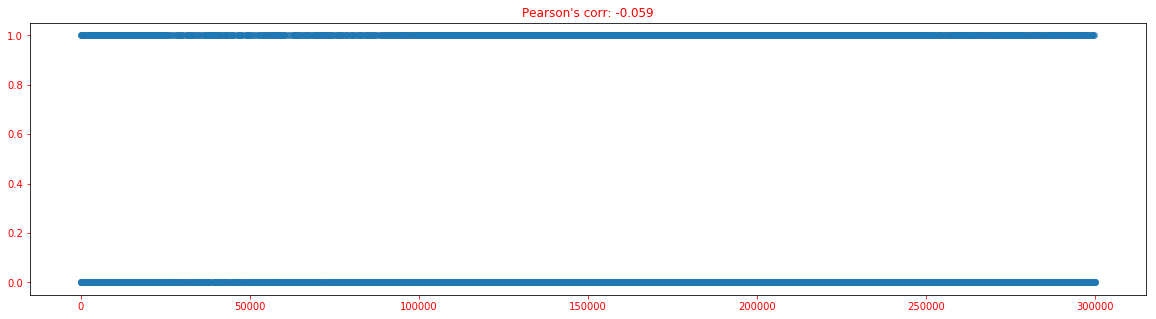

In [ ]:
# Show Pearson Correlation Coefficient Between Cum. Full Service Time in LTE vs Users Satisfaction
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
x = dataset.Cumulative_Full_Service_Time_LTE
y = ground_truth.copy()
ax.plot(x, y, 'o', alpha=0.3)
ax.set_title("Pearson's corr: {:.3f}".format(x.corr(y)), color='red')
ax.xaxis.label.set_color('red')
ax.yaxis.label.set_color('red')
ax.tick_params(axis='x', colors='red')
ax.tick_params(axis='y', colors='red')

# Prediction Pipeline

## Select ML Classifiers, HP Candidate Values and K-Fold Validation Structure

In [10]:
# Choose k of K-Dold Validation Procedure
splits = 2

# Select ML Classifiers
names = ["Logistic Regression"]
raw_classifiers = [LogisticRegression(penalty='l2', solver='lbfgs')] #: LR model has 1 Hyper-Parameter, which is the 
# regularisaton coefficient C. Its value should be tuned according to a K-Fold Validation Procedure.

# Choose Hyper-Parameters Candidate Values 
parameters_grid = [{'C': [0.1,1,5]}]#LR: in this example a grid search is performed over a set of 3 candidate
                                        # values for hyper-parameter C


## Tune ML Classifiers through a K-Fold Validation

In [11]:
## NORMALISE DATA
mean = dataset.mean(axis=0)
std = dataset.std(axis=0)
dataset = (dataset - mean) / std
dataset.dropna(inplace=True) #check data consistency

# Print Info
print(20*'*')
print('% of Class 1 in Training : ', len(dataset[dataset == 1]) / len(dataset),
      '; % of Class 0 in Training: ', len(dataset[dataset == 0]) / len(dataset))
print('Shape Training Set :', dataset.shape, ',', dataset.shape)
print(20*'*')

# Select Best Hyperparameter Value for This Fold
hp_values = hyperparameter_tuning(dataset, ground_truth, names, 
                      raw_classifiers, parameters_grid, n_splits_in=splits)

hp_values.head()


********************
% of Class 1 in Training :  1.0 ; % of Class 0 in Training:  1.0
Shape Training Set : (18970, 12) , (18970, 12)
********************
Choose Best hyper-parameters through Cross Validation
############
 Classifier Logistic Regression - Processing


TypeError: __init__() got an unexpected keyword argument 'iid'

## Evaluate Performance on Test Set, where each ML Classifier work with best HP Values 

In [13]:
# Import Test Data
basic_test = pd.read_csv(path+'BasicDataset_Test_MRN.csv')
dataset_test = basic_test.drop(['User_Satisfaction','Unnamed: 0', 'Unnamed: 0.1'], axis=1)
ground_truth_test = basic_test.loc[:, 'User_Satisfaction'].copy()
print('Test Data:', dataset_test.shape)
print('Test Target:', ground_truth_test.shape)


# Select ML Classifiers and Fix the HP Values to the best values found in previous iteration
# of the pipeline
names = ["Logistic Regression"]
reg_coeff = hp_values.loc["Logistic Regression","BestHP_Values"][0]
classifiers = [LogisticRegression(C = reg_coeff, penalty='l2', solver='lbfgs')]

## NORMALISE DATA (Always with refer to Train Data)
dataset_test = (dataset_test - mean) / std
dataset_test.dropna(inplace=True) #check data consistency

# Print Info
print(20*'*')
print('% of Class 1 in Testing : ', len(dataset_test[dataset_test == 1]) / len(dataset_test),
      '; % of Class 0 in Testing: ', len(dataset_test[dataset_test == 0]) / len(dataset_test))
print('Shape Test Set :', dataset_test.shape, ',', dataset_test.shape)
print(20*'*')

# Print Performance on Test Set
performance = direct_prediction(dataset, ground_truth, 
                                dataset_test, ground_truth_test, 
                                names, classifiers)

performance.head()

Test Data: (4743, 12)
Test Target: (4743,)


NameError: name 'hp_values' is not defined